# CoinAPI

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg

In [65]:
import requests
import json

symbol_id = 'ADA'
period_id = '1DAY'
time_start = '2019-05-03T00:00:00'
time_end = '2021-05-04T00:00:00'
limit = '1000'

url = f'https://rest.coinapi.io/v1/ohlcv/{symbol_id}/USD/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}'
#url = 'https://rest.coinapi.io/v1/symbols'

headers = {
  'Accepts': 'application/json',
  'X-CoinAPI-Key': 'B578CC73-E598-48F9-AA88-86F637222F8D',
}


response = requests.get(url, headers=headers)
data = json.loads(response.text)

In [66]:
df = pd.DataFrame(data)
df = df.drop(['time_period_end', 'time_open', 'time_close'], axis=1)

In [67]:
df['Date'] = pd.to_datetime(df['time_period_start']).dt.date
df = df.set_index(pd.DatetimeIndex(df['Date'])).drop(['time_period_start', 'Date'], axis=1)
df.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2019-05-03,0.067104,0.074000,0.066500,0.068826,1.105210e+07,1673
2019-05-04,0.069083,0.070949,0.065203,0.066269,8.567252e+06,1145
2019-05-05,0.066259,0.067266,0.064820,0.065500,3.166601e+06,388
2019-05-06,0.065252,0.068150,0.062891,0.066150,4.416848e+06,774
2019-05-07,0.066446,0.068239,0.062900,0.063100,5.940077e+06,1024


In [160]:
df.tail()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2021-04-29,1.3390,1.412400,1.267658,1.3076,1.323343e+08,158451
2021-04-30,1.3066,1.373046,1.287936,1.3556,7.658501e+07,123272
2021-05-01,1.3556,1.370000,1.310000,1.3537,5.661885e+07,114347
2021-05-02,1.3535,1.357500,1.295265,1.3284,4.534578e+07,91729
2021-05-03,1.3284,1.381600,1.322300,1.3634,7.371871e+07,132431


<AxesSubplot:xlabel='Date'>

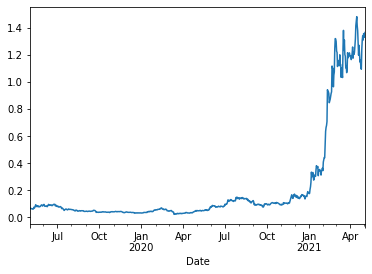

In [95]:
df['price_close'].plot()

In [94]:
X = df['price_close'].apply(np.log).values
forecast = 7
X_train, X_test = X[1:len(X)-forecast], X[len(X)-forecast:]

In [171]:
def hit_rate(true, pred):
    is_neg = lambda x: 0 if x > 0 else 1
    pos_true = []
    pos_hat = []
    for t in range(len(true)-1):
        pos_true.append(is_neg(np.sign(true[t] - true[t+1])))
        pos_hat.append(is_neg(np.sign(pred[t] - pred[t+1])))
    subtracted = np.abs(np.subtract(pos_hat, pos_true))
    rate = 1 - sum(subtracted)/len(subtracted)
    return rate

def model_selection(data, forecast):
    X_train, X_test = data[1:len(data)-forecast], data[len(data)-forecast:]
    
    # find lag values which maximize hit rate
    rates = []
    for lag in range(1,int(len(X_train)/2)-1):
        autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
        X_hat = autoreg.forecast(forecast)
        rates.append(hit_rate(X_test, X_hat))
    
    max_hit_lags = [i for i, j in enumerate(rates) if j == max(rates)]
    
    # find lag values which minimize MSE
    mses = []
    for lag in max_hit_lags:
        autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
        X_hat = autoreg.forecast(forecast)
        mses.append(mean_squared_error(X_test, X_hat))
    
    min_mse_lags = [max_hit_lags[i] for i, j in enumerate(mses) if j == min(mses)]
    
    # Fit model
    autoreg = AutoReg(X_train, lags=min_mse_lags[0], old_names=True).fit()
    X_hat = autoreg.forecast(forecast)
    
    plt.plot(X_test, marker='o', label='Observed')
    plt.plot(X_hat, marker='o', label='Predicted')
    plt.legend()
    print("Lag:", min_mse_lags[0])
    print("Hit rate:", rates[min_mse_lags[0]])
    print("Mean Squared Error:", min(mses))
    
    return min_mse_lags[0]

Lag: 17
Hit rate: 0.8333333333333334
Mean Squared Error: 0.0026602372205052106


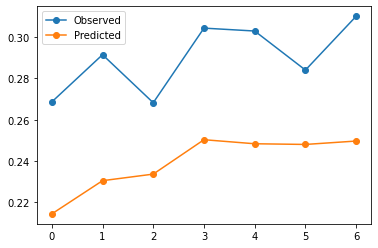

In [172]:
lag_order = model_selection(X, 7)

Text(0.5, 0, 'Days Since ')

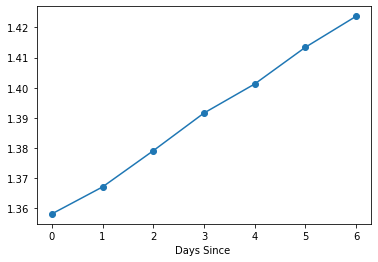

In [173]:
autoreg = AutoReg(X, lags=lag_order, old_names=True).fit()
X_hat = autoreg.forecast(7)
plt.plot(np.exp(X_hat), marker='o')
plt.xlabel('Days Since ')

In [161]:
np.exp(X[:-7])

array([0.068826, 0.066269, 0.0655  , 0.06615 , 0.0631  , 0.064019,
       0.061305, 0.063069, 0.075305, 0.070487, 0.072947, 0.0849  ,
       0.094181, 0.087906, 0.083012, 0.0789  , 0.086824, 0.085107,
       0.084652, 0.07726 , 0.080885, 0.08099 , 0.080427, 0.086162,
       0.09048 , 0.093   , 0.090921, 0.083934, 0.089212, 0.090178,
       0.0965  , 0.087513, 0.082288, 0.082756, 0.083005, 0.085436,
       0.083839, 0.079137, 0.085481, 0.088085, 0.096481, 0.0893  ,
       0.090591, 0.091441, 0.092117, 0.093448, 0.0887  , 0.08974 ,
       0.087526, 0.089762, 0.093867, 0.096167, 0.0978  , 0.09596 ,
       0.096416, 0.084912, 0.08855 , 0.08953 , 0.082022, 0.08311 ,
       0.080532, 0.082733, 0.077477, 0.0765  , 0.07726 , 0.080156,
       0.080242, 0.078143, 0.071533, 0.064872, 0.069532, 0.06664 ,
       0.062183, 0.059247, 0.051754, 0.055107, 0.058694, 0.059908,
       0.062769, 0.061185, 0.05938 , 0.055618, 0.05873 , 0.058702,
       0.0629  , 0.05978 , 0.05935 , 0.060293, 0.059986, 0.060